In [1]:
# ! -*- coding: utf-8 -*-
import os.path
import torch
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModel,GPT2Tokenizer
import numpy as np

import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, Trainer, TrainingArguments,GPT2DoubleHeadsModel,GPT2PreTrainedModel,GPT2ForSequenceClassification
from datasets import load_dataset

# 定义标记器和模型配置
tokenizer = GPT2Tokenizer.from_pretrained(r"D:\system\桌面\lcm-code\tokenizers_lcm\tokenizer_gpt100.json")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id

from torch import nn
from transformers import AutoModelForSequenceClassification,GPT2ForSequenceClassification,GPT2Config
from torch.nn.utils import prune
class GPT2cls(nn.Module):
    def __init__(self,drop,purn,n_block):
        super(GPT2cls, self).__init__()
        self.config = GPT2Config.from_pretrained('D:\system\桌面\lcm-code\pre_training\chem_gpt100')  #  使用预训练的GPT2模型
        self.config.pad_token_id=tokenizer.pad_token_id
        self.config.num_labels=2
        self.config.num_attention_heads=4
        self.config.num_hidden_layers=n_block
        self.config.hidden_size=512
        self.model = AutoModelForSequenceClassification.from_config(self.config)
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
                module.p = drop
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=purn)
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids,attention_mask=attention_mask,output_attentions=True)
        return outputs



model=GPT2cls(0.144,0.2,3)
model.load_state_dict(torch.load('best_val.model'))

<All keys matched successfully>

In [2]:
from datasets import load_from_disk

data_dict=load_from_disk('test_name')
data_dict


Dataset({
    features: ['smiles', 'ids', 'Ames Mutagenicity', 'names'],
    num_rows: 573
})

In [3]:
# 打印
import seaborn as sns
import torch
import torch
def attention_plot(names,smi,attention, x_texts, y_texts=None, figsize=(25, 20), annot=False, figure_path='./figures',
                   figure_name='attention_weight.png'):
    plt.style.use('ggplot')
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.clf()
    fig, ax = plt.subplots(figsize=figsize,dpi=300)
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width*20, bbox.height*20

    rows, cols = attention.shape

    # 计算自适应字体大小
    fontsize = int(0.9 * min(width / cols, height / rows))

    sns.set(font_scale=2.5)
    hm = sns.heatmap(attention,
                     cbar=True,
                     cmap="RdBu_r",
                     annot=annot,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': fontsize},
                     yticklabels=y_texts,
                     xticklabels=x_texts,
                     )
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold',fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold',fontsize=fontsize)

    ax.text(0.5, 1.05, names, ha='center', va='bottom', fontsize=50, transform=ax.transAxes)


    ax.text(0.5, -0.1, smi, ha='center', va='bottom', fontsize=50, transform=ax.transAxes)
    rect = plt.Rectangle((0, len(y_texts)-1), len(x_texts), 1, fill=False, edgecolor='red', lw=3)
    ax.add_patch(rect)


    if os.path.exists(figure_path) is False:
        os.makedirs(figure_path)
    plt.savefig(os.path.join(figure_path, figure_name))
    plt.close()

In [4]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset
import re

# \t is the tab character in Python
tokenized_dataset = data_dict.map(
    lambda element: tokenizer(element['smiles']), batched=True
)

tokenized_dataset = tokenized_dataset.select_columns(['smiles','input_ids', 'attention_mask', 'names'])


tokenized_dataset=tokenized_dataset.filter(lambda x:x['names'] is not None )
tokenized_dataset = tokenized_dataset.map(lambda x: {'names': re.sub(r'[^\x00-\x7F]+', '', x['names']).replace(' ', '-').replace('/', '-').replace('[', '-').replace(']', '-')}).select(range(300))
# tokenized_dataset = tokenized_dataset.map(lambda x: {'names': re.sub(r'[^\x00-\x7F]+', '', x['names']).replace(' ', '-').replace('/', '-').replace('[', '-').replace(']', '-')}).select(range(300, len(tokenized_dataset)))

tokenized_dataset=tokenized_dataset.filter(lambda x:x['names']!='2--4-hydroxy-2-(hydroxymethyl)-6---6-methoxy-7,9,13-trimethyl-6--3-methyl-4--3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl-oxybutyl--5-oxapentacyclo-10.8.0.02,9.04,8.013,18-icos-18-en-16-yl-oxy--5-(3,4,5-trihydroxy-6-methyloxan-2-yl)oxyoxan-3-yl-oxy-6-methyloxane-3,4,5-triol')
tokenized_dataset

Dataset({
    features: ['smiles', 'input_ids', 'attention_mask', 'names'],
    num_rows: 299
})

In [5]:
test_dataloader=DataLoader(tokenized_dataset,batch_size=1)


In [6]:
for idx, batch in enumerate(test_dataloader):
    model.eval()
    inputs = torch.cat(batch['input_ids'])
    attention = torch.cat(batch['attention_mask'])
    ids = np.array(inputs, dtype=np.int64)
    texts = tokenizer.convert_ids_to_tokens(ids)
    outputs = model(input_ids=torch.unsqueeze(inputs, dim=0), attention_mask=torch.unsqueeze(attention, dim=0)).attentions

    attentions = outputs[0]

    attention_mean = torch.mean(attentions, axis=1)

    name = batch['names'][0]
    # Attention 归一化
    attentions_norm = torch.nn.functional.normalize(attention_mean, dim=-1, p=1)
    attention_plot(name, batch['smiles'][0], attentions_norm[0, :, :].detach().numpy(), x_texts=texts, y_texts=texts, annot=True, figsize=(24, 20),
                   figure_path='.\explain',
                   figure_name=rf'{name}.png')

    # 释放内存
    del inputs, attention, ids, texts, outputs, attentions, attention_mean, attentions_norm



<Figure size 640x480 with 0 Axes>

In [13]:
inputs=tokenizer('Nc1cc(ccc1CO)[N+](=O)[O-]',return_tensors='pt')
inputs

{'input_ids': tensor([[32, 49,  9, 49, 49,  2, 49, 49, 49,  9, 78, 85, 32, 95, 69, 33, 85, 33,
         91]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [0]:
model(inputs['input_ids'],inputs['attention_mask']).logits

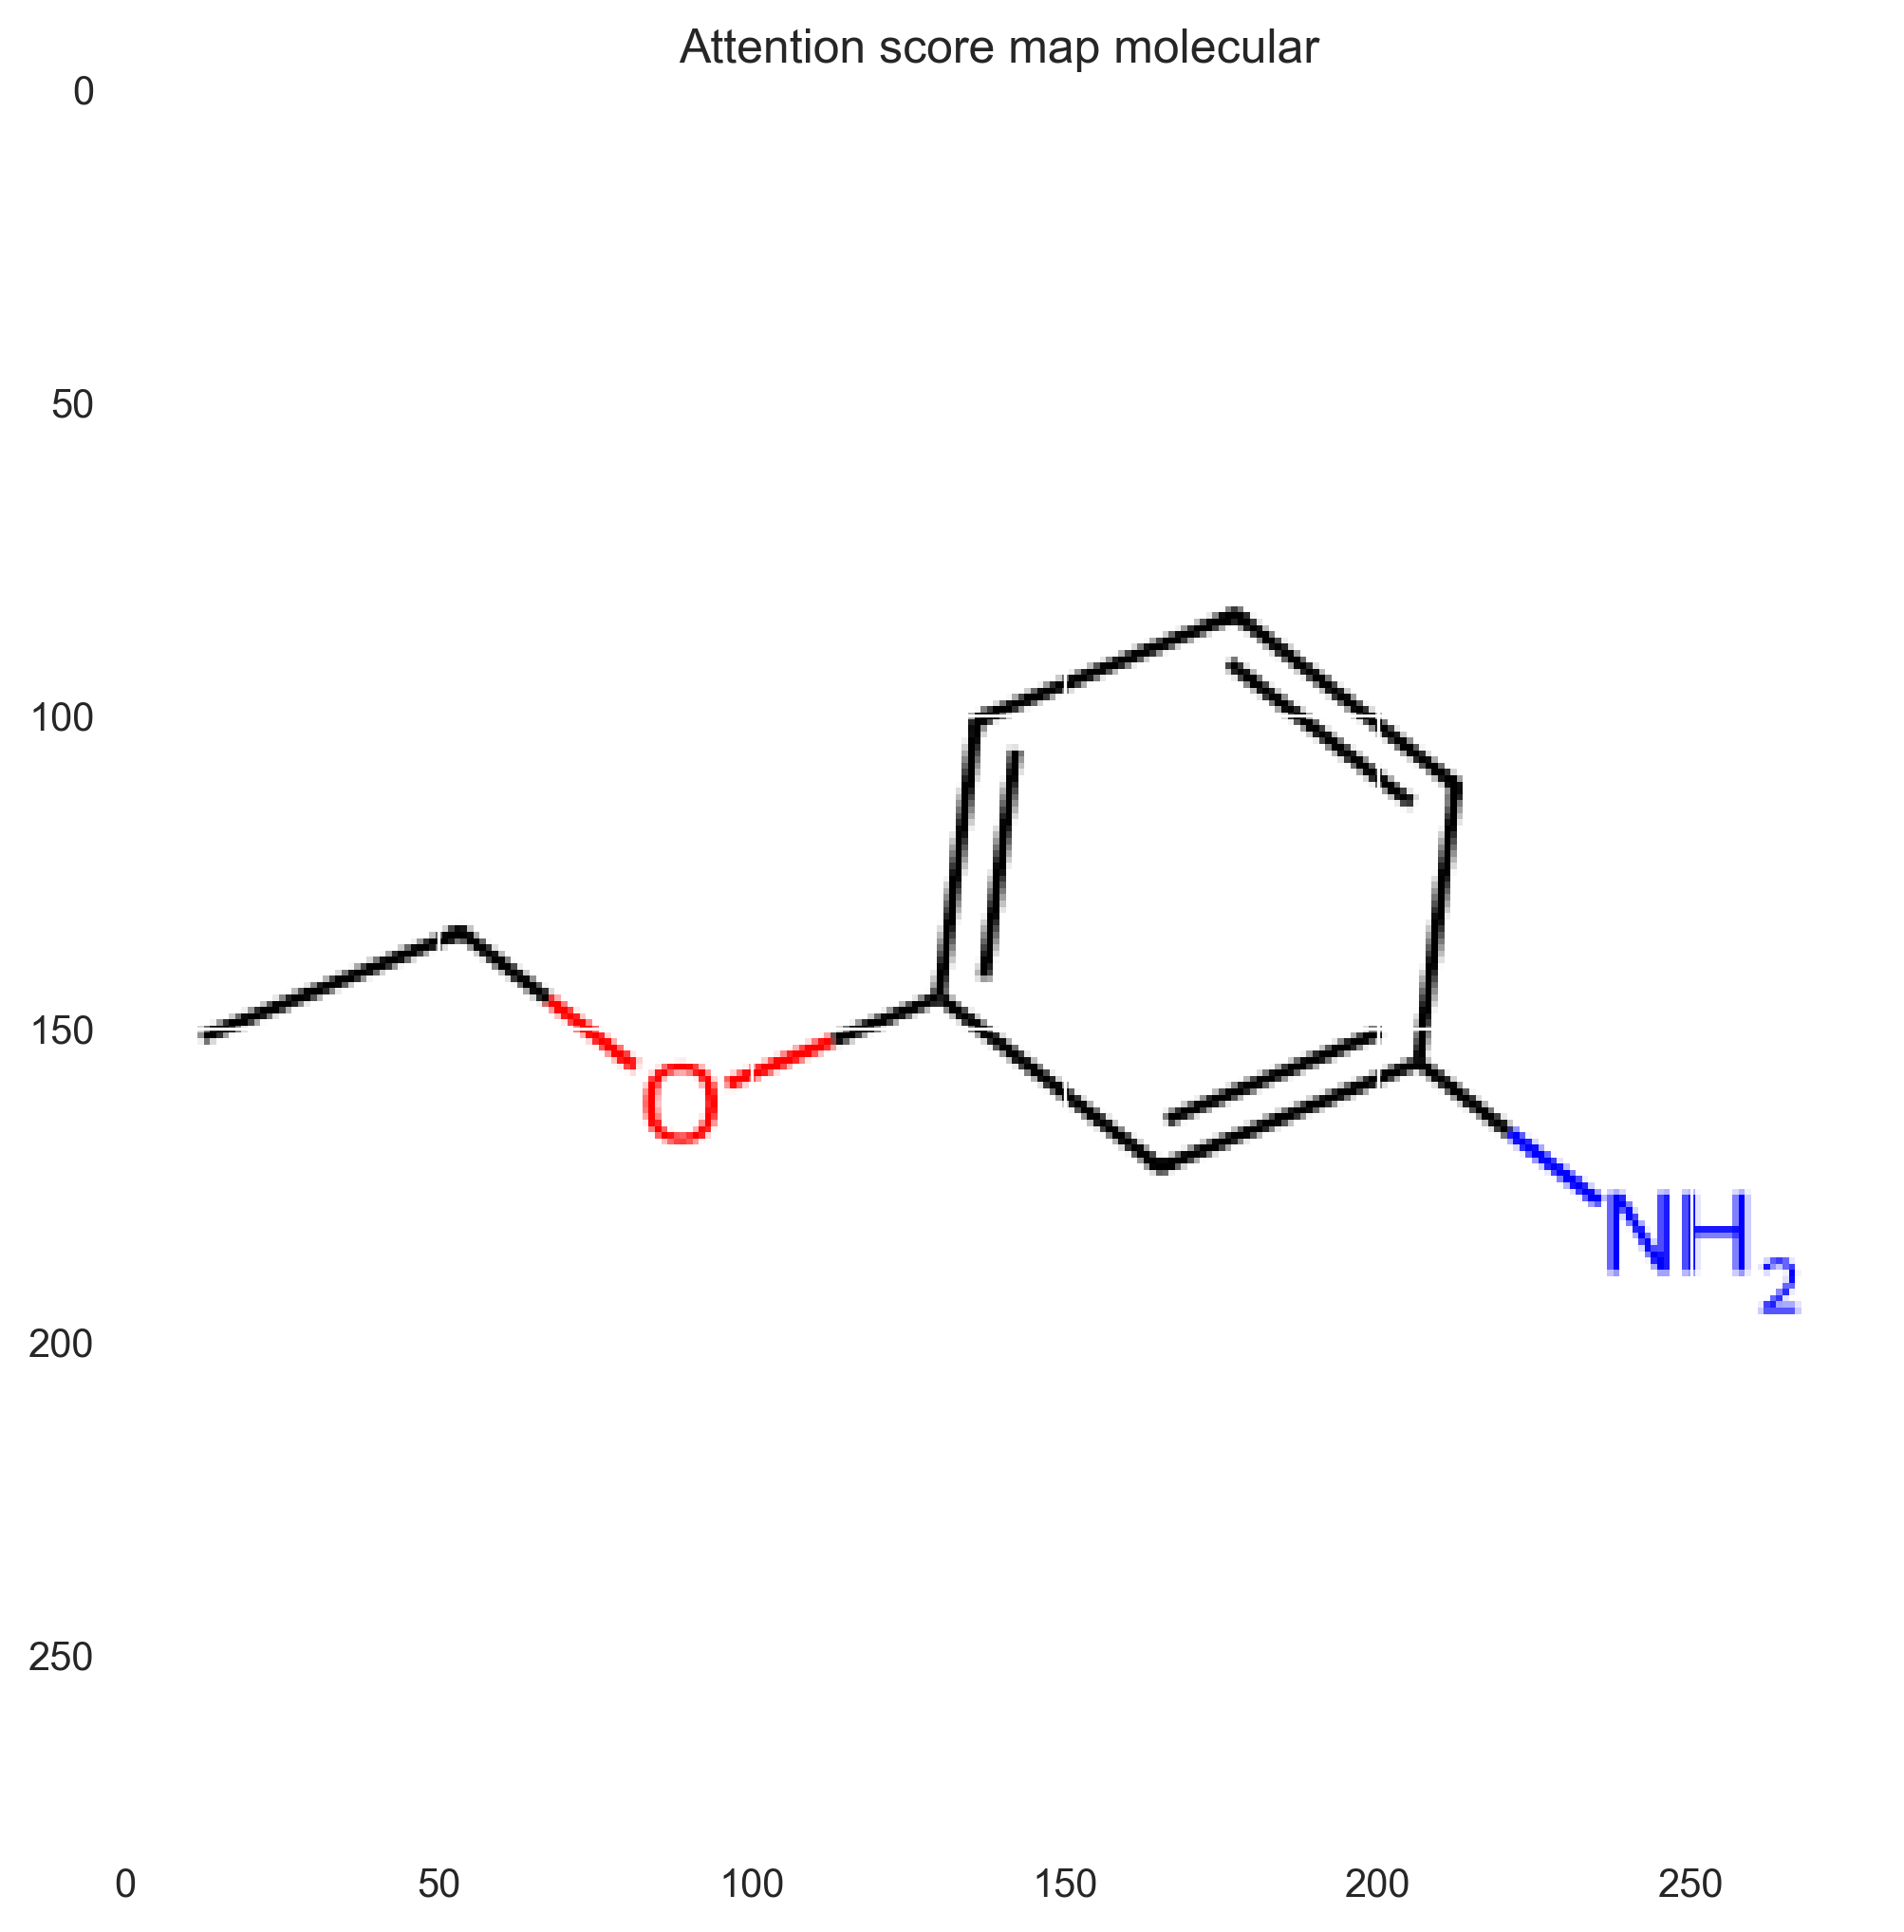

In [40]:
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import rdDepictor, rdmolops
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib
import matplotlib.cm as cm
from skimage.io import imread
from cairosvg import svg2png
import os



def img_for_mol(mol, atom_weights=[]):
    # print(atom_weights)
    highlight_kwargs = {}
    if len(atom_weights) > 0:
        norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
        cmap = matplotlib.colormaps['bwr']
        plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
        atom_colors = {
            i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))
        }
        highlight_kwargs = {
            'highlightAtoms': list(range(len(atom_weights))),
            'highlightBonds': [],
            'highlightAtomColors': atom_colors,
            'highlightBondColors':[]
        }
        # print(highlight_kwargs)

    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(6)

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, **highlight_kwargs)
                        # highlightAtoms=list(range(len(atom_weights))),
                        # highlightBonds=[],
                        # highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    svg2png(bytestring=svg, write_to='tmp.png', dpi=600)
    img = imread('tmp.png')


    os.remove('tmp.png')

    return img

mol = Chem.MolFromSmiles('CCOc1cccc(c1)N')
# img = img_for_mol(mol, atom_weights=[0.05,0.05,0.02,0.01,0.01,0.05,0.01,0.2,0.02,0.17,0.04,0.02])
img = img_for_mol(mol)
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8),dpi=300)

# Display the image
ax.imshow(img)

# Set title and axis labels
ax.set_title('Attention score map molecular')


plt.show()